## Classificação de documentos

Imagine trabalhar em uma empresa prestigiada de jornal ou revista com um vasto arquivo de documentos que remonta ao longo da história. Em meio a esse tesouro de informações, surge uma tarefa monumental: organizar esses documentos históricos em seções de tópicos relevantes. Essa curadoria estratégica não apenas aprimora a experiência do usuário, oferecendo conteúdo mais acessível, mas também traz uma nova perspectiva para insights inestimáveis do passado. No entanto, o volume e a abrangência dessa empreitada exigem uma solução sofisticada.

A implementação de um sistema automatizado de aprendizado de máquina torna esse processo muito mais eficiente. Tal sistema, equipado com capacidades avançadas de processamento de linguagem natural e aprendizado de máquina, poderia examinar o vasto arquivo, categorizando os artigos em tópicos específicos com precisão notável. O resultado é uma experiência em que os leitores acessam um grande acervo de conhecimento alinhado aos seus interesses, enquanto a equipe editorial ganha agilidade na gestão de conteúdo.

Este projeto tem como objeto classificar artigos de notícias para um mecanismo de busca de conteúdo. Para isso, é construir um modelo que categorize automaticamente os artigos em diferentes tópicos ou classes, permitindo que o mecanismo de busca entregue conteúdo relevante aos usuários de forma eficiente. Será utilizada a biblioteca torchtext, que simplifica o processo de criação de um conjunto de dados para análise de classificação de texto.

Com o torchtext, temos a flexibilidade para acessar e pré-processar dados brutos de notícias de maneira simples. A biblioteca permite converter strings de texto em torch.Tensors, essenciais para o treinamento de modelos de aprendizado de máquina. Ao utilizar as funcionalidades práticas do torchtext, podemos configurar um pipeline de processamento de dados eficiente, que prepara seus dados textuais para a classificação.

Além disso, o projeto também vai embaralhar e iterar efetivamente pelos dados processados usando o torch.utils.data.DataLoader. Esse DataLoader simplifica o manuseio dos dados, permitindo que você foque na construção e no treinamento do seu modelo de classificação de texto de forma eficaz.

### Objetivos

- Trabalhar com conjuntos de dados e entender tokenizador, técnica de embedding bag e vocabulário.
- Explorar embeddings no PyTorch e compreender índices de tokens.
- Realizar classificação de texto usando data loader e aplicá-lo em um modelo de rede neural.
- Treinar o modelo de classificação de texto em um conjunto de dados de notícias.

### Preparar setup - instalar bibliotecas

In [1]:
def warn(*args, **kwargs):
    pass
    
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import importlib.util
import subprocess
import sys

def check_and_install(package, pip_name=None):
    if pip_name is None:
        pip_name = package
    spec = importlib.util.find_spec(package)
    if spec is None:
        print(f"{package} não está instalado. Instalando...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
    else:
        print(f"{package} já está instalado.")

In [2]:
check_and_install('portalocker')
check_and_install('torchtext')
check_and_install('torchdata')
check_and_install('plotly')
check_and_install('dash')

portalocker já está instalado.
torchtext já está instalado.
torchdata já está instalado.
plotly não está instalado. Instalando...
dash não está instalado. Instalando...


### Importar bibliotecas

In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go

from torchtext.data.utils import get_tokenizer

### Definir funções auxiliares

In [4]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

### Importar banco de dados

In [8]:
train_iter = iter(AG_NEWS(split='train'))

O conjunto de dados AG_NEWS em torchtext não suporta indexação direta como uma lista ou tupla. Não é um conjunto de dados de acesso aleatório, mas sim um conjunto de dados iterável que precisa ser usado com um iterador. Essa abordagem é mais eficaz para dados de texto.

In [9]:
y, text = next((train_iter))
print(y, text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


#### Etiqueta da amostra

In [10]:
ag_news_label = {1: "World", 
                 2: "Sports", 
                 3: "Business", 
                 4: "Sci/Tec"}
ag_news_label[y]

'Business'

Usar o dataset para encontrar todas as classes

In [11]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class 

4

#### Criar os tokens

In [12]:
tokenizer = get_tokenizer('basic_english')

In [13]:
def yield_tokens(data_iter):
    for _,text in data_iter:
        yield tokenizer(text)

In [15]:
vocab = build_vocab_from_iterator(yield_tokens(train_iter),
                                  specials=["<unk>"]
                                 )
vocab.set_default_index(vocab["<unk>"])

In [17]:
# Test
vocab(["age","hello"])

[0, 0]

### Dataset
Você pode converter o conjunto de dados em conjuntos de dados no estilo de mapa e, em seguida, executar uma divisão aleatória para criar conjuntos de dados de treinamento e validação separados. O conjunto de dados de treinamento conterá 95% das amostras, enquanto o conjunto de dados de validação conterá os 5% restantes. Esses conjuntos de dados podem ser usados ​​para treinar e avaliar um modelo de aprendizado de máquina para classificação de texto no conjunto de dados AG_NEWS.

In [19]:
# Split the dataset into training and testing iterators
train_iter, test_iter = AG_NEWS()

In [21]:
# Convert the training and testing iterators to map-style dataset
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

In [22]:
# Determine the number of samples to be used for training and 
# validation (5% for validation)
num_train = int(len(train_dataset) * 0.95)

In [23]:
# Randomly split the training dataset into training and 
#  validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, 
#  and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset,
                                          [num_train, len(train_dataset) - num_train]
                                         )

Verificar a disponibilidade de GPU para processamento

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Dataloader
Prepare o pipeline de processamento de texto com o tokenizer e o vocabulário. Os pipelines de texto e rótulo serão usados ​​para processar as strings de dados brutos dos iteradores do conjunto de dados.

A função `text_pipeline` tokenizará o texto de entrada e o `vocab` será então aplicado para obter os índices do token. O `label_pipeline` garantirá que os rótulos comecem em zero.

In [26]:
def text_pipeline(x):
    return vocab(tokenizer(x))

In [28]:
def label_pipeline(x):
    return int(x) - 1

No PyTorch, a função collate_fn é usada em conjunto com data loaders para personalizar a forma como os batches são criados a partir de amostras individuais. O código fornecido define uma função collate_batch no PyTorch, utilizada com data loaders para personalizar a criação de batches a partir das amostras individuais. Essa função processa um batch de dados, incluindo rótulos e sequências de texto. Ela aplica as funções `label_pipeline` e `text_pipeline` para pré-processar os rótulos e os textos, respectivamente.

Os dados processados são, então, convertidos em tensores do PyTorch e retornados como uma tupla contendo o tensor de rótulos, o tensor de texto e o tensor de offsets, que representa as posições iniciais de cada sequência de texto no tensor combinado. A função também garante que os tensores retornados sejam movidos para o dispositivo especificado (e.g., GPU) para uma computação eficiente.

In [30]:
def collate_batch(batch):
    label_list, text_list, offsets = [],[],[0]

    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)

    return label_list.to(device), text_list.to(device), offsets.to(device)
    

Converta os objetos do Dataset em um Dataloader aplicando a função collate.

In [31]:
BATCH_SIZE = 64

In [32]:
train_dataloader = DataLoader(
    split_train_, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch
)

In [33]:
valid_dataloader = DataLoader(
    split_valid_, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_batch
)

In [34]:
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_batch
)

In [35]:
label, text, offsets=next(iter(valid_dataloader ))
label, text, offsets

(tensor([1, 2, 2, 0, 3, 2, 0, 3, 0, 1, 0, 2, 1, 2, 0, 3, 2, 1, 1, 1, 3, 3, 2, 2,
         0, 0, 2, 1, 3, 0, 2, 1, 1, 1, 3, 1, 2, 3, 1, 3, 1, 1, 1, 1, 3, 2, 0, 1,
         1, 1, 3, 3, 2, 0, 2, 0, 1, 3, 1, 0, 3, 1, 1, 1]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([   0,   45,   89,  128,  176,  234,  269,  292,  337,  374,  409,  453,
          496,  539,  581,  621,  659,  709,  746,  799,  831,  870,  898,  940,
          977, 1034, 1073, 1116, 1152, 1177, 1202, 1245, 1292, 1335, 1386, 1418,
         1458, 1495, 1529, 1568, 1609, 1658, 1692, 1730, 1761, 1800, 1854, 1899,
         1941, 1980, 2017, 2051, 2119, 2163, 2209, 2246, 2311, 2359, 2412, 2444,
         2491, 2525, 2571, 2628]))

#### Rede Neural
Criar uma rede neural para um modelo de classificação de texto usando uma camada EmbeddingBag, seguida por uma camada de saída softmax. Inicializar o modelo usando um método específico.

In [36]:
from torch import nn

In [42]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [43]:
# embedding dimension size
emsize = 64

# vocabulary size to determine the number of embeddings
vocab_size = len(vocab)
vocab_size

1

In [44]:
# umber of classes for the output layer
num_class

4

In [45]:
# Creating the model
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
model

TextClassificationModel(
  (embedding): EmbeddingBag(1, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [46]:
predicted_label = model(text,offsets)

A linha de código `predict_label=model(text, offsets)` é usada para obter rótulos previstos de um modelo de aprendizado de máquina para um texto de entrada fornecido e seus deslocamentos correspondentes.

In [47]:
predicted_label.shape

torch.Size([64, 4])

verifica a forma de saída do seu modelo. Neste caso, o modelo é treinado com um tamanho de mini-lote de 64 amostras. A camada de saída do modelo produz quatro logits para cada neurônio, correspondendo às quatro classes na tarefa de classificação. Você também pode criar uma função para encontrar a precisão dada a um conjunto de dados.

In [51]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))

        return ag_news_label[output.argmax(1).item() + 1]

A função predict pega um texto e um pipeline de texto, que pré-processa o texto para aprendizado de máquina. Ela usa um modelo pré-treinado para prever o rótulo do texto para classificação de texto no conjunto de dados AG_NEWS. A função retorna o rótulo previsto como resultado.

In [53]:
predict("I like sports", text_pipeline)

'World'

In [54]:
predict("I like so much Star Wars", text_pipeline)

'World'

Criar uma função para avaliar a precisão do modelo em um conjunto de dados.

In [55]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count

In [56]:
evaluate(test_dataloader)

0.25

O modelo foi avaliado e descobriu-se que seu desempenho não é melhor que a média. Esse resultado é esperado, considerando que o modelo ainda não passou por nenhum treinamento.

### Treinar o Modelo
Defina a taxa de aprendizado (learning rate, LR) como 0,1, o que determina o tamanho do passo em que o otimizador atualiza os parâmetros do modelo durante o treinamento. O critério `CrossEntropyLoss` é usado para calcular a perda entre as saídas previstas pelo modelo e os rótulos verdadeiros. Essa função de perda é comumente empregada para tarefas de classificação multiclasse.

O otimizador escolhido é o `Stochastic Gradient Descent (SGD)`, que otimiza os parâmetros do modelo com base nos gradientes computados em relação à função de perda. O otimizador SGD usa a taxa de aprendizado especificada para controlar o tamanho das atualizações de peso.

Além disso, um agendador de taxa de aprendizado (learning rate scheduler) é definido usando `StepLR`. Esse agendador ajusta a taxa de aprendizado durante o treinamento, reduzindo-a por um fator (gamma) de 0,1 após cada época (passo) para melhorar a convergência e ajustar o desempenho do modelo. Esses componentes juntos formam a configuração essencial para o treinamento de uma rede neural usando a taxa de aprendizado especificada, critério de perda, otimizador e agendador de taxa de aprendizado.

In [62]:
LR = 0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [64]:
EPOCHS = 10
cum_loss_list = []
acc_epoch = []
acc_old = 0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss = 0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.1)
        optimizer.step()
        cum_loss += loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
        acc_old = accu_val
        torch.save(model.state_dict(), "my_model.pth")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.52s/it]


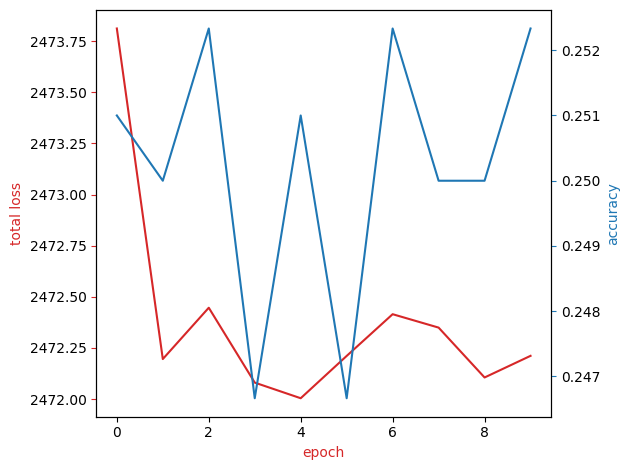

In [65]:
plot(cum_loss_list,acc_epoch)

In [66]:
evaluate(test_dataloader)

0.25

O código abaixo fornece um resumo para gerar uma visualização 3D t-SNE de embeddings usando Plotly. Ele demonstra como palavras que são semelhantes entre si são posicionadas mais próximas umas das outras.

In [68]:
# Get the first batch from the validation data
batch = next(iter(valid_dataloader))

# Extract the text and offsets from the batch
label, text, offsets = batch

# Send the data to the device (GPU if available)
text = text.to(device)
offsets = offsets.to(device)

# Get the embeddings bag output for the batch
embedded = model.embedding(text, offsets)

# Convert the embeddings tensor to a numpy array
embeddings_numpy = embedded.detach().cpu().numpy()

# Perform t-SNE on the embeddings to reduce their dimensionality to 3D.
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings_numpy)

In [70]:
# Create a 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=X_embedded_3d[:, 0],
    y=X_embedded_3d[:, 1],
    z=X_embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.numpy(),  # Use label information for color
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

layout = go.Layout(title="3D t-SNE Visualization of Embeddings",
                   scene=dict(xaxis_title='Dimension 1',
                              yaxis_title='Dimension 2',
                              zaxis_title='Dimension 3'))

fig = go.Figure(data=[trace], layout=layout)
#fig.show()

### Prever

In [71]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

In [75]:
result = predict(article, text_pipeline)

markdown_content = f'''
<div style="background-color: lightgray; padding: 8px;">
    <h4>{article}</h4>
</div>
<div>
<h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)


<div style="background-color: lightgray; padding: 8px;">
    <h4>Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points.</h4>
</div>
<div>
<h4>The category of the news article: Sci/Tec</h4>
</div>


____
Esse material tem como referência o curso [Generative AI and LLMs: Architecture and Data Preparation](https://www.coursera.org/learn/generative-ai-llm-architecture-data-preparation?specialization=generative-ai-engineering-with-llms)